<span style='font-size:x-large'>1 7CCFM06 Final Coursework</span>


In [3]:
import numpy as np
import scipy
import sympy as sp
import random
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import norm
from numpy.random import seed
from numpy.random import randint

In [4]:
#Constants required for each question

S0 = 103
K = 126 
T= 1.6
mu = 0.14
r = 0.01

In [5]:
#Functions required for each question

def construct_vol(n):
    times = np.linspace(0, T, n+1)
    vol = np.zeros(n+1)
    for i in range(0,n+1):
        if times[i] < 0.5:
            vol[i] = 0.12 + 0.1*(times[i]/0.5)
        else:
            vol[i] = 0.22
    return vol

def simulate_stock_price_mult(S0, mu, T, n, n_paths):
    v = construct_vol(n)
    times = np.linspace(0, T, n+1)
    epsilon = np.random.randn(n_paths, n)
    Z = np.zeros([n_paths, n+1])
    dt = T/n
    Z[:,0] = np.log(S0)
    for i in range(0, n):
        #epsilon = np.random.randn(n)
        if times[i] < 0.5:
            Z[:,i+1] = Z[:,i] + (mu - 0.5*(v[i]**2))*dt + (v[i])*np.sqrt(dt)*epsilon[:,i]
        else:
            Z[:,i+1] = Z[:,i] + (mu - 0.5*(0.22**2))*dt + (0.22)*np.sqrt(dt)*epsilon[:,i]
    return np.exp(Z), times

def simulate_stock_price_constant(S0, mu, sigma, T, n, n_paths):
    Z = np.zeros([n_paths, n+1])
    dt = T/n
    Z[:,0] = np.log(S0)
    times = np.linspace(0, T, n+1)
    epsilon = np.random.randn(n_paths, n)
    
    for i in range(0, n):
        Z[:,i+1] = Z[:,i] + (mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*epsilon[:,i]
     
    S = np.exp(Z)
    
    return S, times
    
def construct_s_t(n):
    times = np.linspace(0, T, n+1)
    s_t = np.zeros(n+1)
    for j in range(0, n):
        s1 = 223/15000
        s2 = (25*(times[j]**3) + 45*(times[j]**2) + 27*(times[j]))/1875
        s3 = (242*T - 121)/5000
        if times[j] < 0.5:
            s_t[j] = (((1/(T-times[j]))*((s1 - s2) + s3)))**0.5
        else:
            s_t[j] = 0.22
        s_t[-1] = s_t[-2]
    return s_t, times

#Black and Scholes Call:

def N(x):
    return scipy.stats.norm.cdf(x)

def N_pdf(x):
    return scipy.stats.norm.pdf(x)

def compute_d1_and_d2( S, t, K, T, r, s): 
    t_exp = (T - t)
    d1 = (1/(s*np.sqrt(t_exp)))*(np.log(S/K) + (r+0.5*s**2)*t_exp) 
    d2 = d1 - s*np.sqrt(t_exp)
    return d1,d2

def black_scholes_call_price(S, t, K, T, r, s): 
    d1, d2 = compute_d1_and_d2(S,t,K,T,r,s) 
    return S*N(d1) - np.exp(-r*(T-t))*K*N(d2)

def black_scholes_delta_call(S,t,K,T,r,s):
    d1, d2 = compute_d1_and_d2(S,t,K,T,r,s) 
    return N(d1)

np.testing.assert_almost_equal( black_scholes_call_price( 100, 0, 110, 0.5, 0.1, 0.2), 3.743, decimal=3)

#Black and Scholes Put:

def black_scholes_put_price(S, t, K, T, r, s):
    d1, d2 = compute_d1_and_d2(S,t,K,T,r,s) 
    return K*np.exp(-r*(T-t))*N(-d2) - S*N(-d1)

def black_scholes_delta_put(S,t,K,T,r,s):
    d1, d2 = compute_d1_and_d2(S,t,K,T,r,s)
    return N(d1) - 1

#Gamma formula (gamma for a call equals gamma for a put)

def black_scholes_gamma(S, t, K, T, r, s):
    d1, d2 = compute_d1_and_d2(S,t,K,T,r,s)
    return N_pdf(d1)/(S*s*np.sqrt(T-t))

In [6]:
#TESTS (100 tests run) for each function:

#Constants for tests:
n_tests = 100
S0_test = 91
mu_test = 0.05
sigma_test = 0.15
T_test = 1.1
n_paths_test = 100

# test construct_sigma(n):
def test_construct_vol():
    n = randint(1, 1000, n_tests)
    for i in n:
        x = construct_vol(i)
        assert x[0] == 0.12
        assert x[-1] == 0.22
        assert len(x) == i+1

def test_construct_s_t():
    q = randint(2, 1000, n_tests)
    for j in q:
        y, ti = construct_s_t(j)
        s1 = 223/15000
        s2 = (25*(ti[j]**3) + 45*(ti[j]**2) + 27*(ti[j]))/1875
        s3 = (242*T - 121)/5000
        assert ti[-1] == T
        assert ti[0] == 0
        assert y[0] == (((1/(T-ti[0]))*((s1 - (25*(ti[0]**3) + 45*(ti[0]**2) + 27*(ti[0]))/1875) + s3)))**0.5
        assert y[-1] == 0.22
        assert len(y) == len(ti) == j+1
        if ti[j] >= 0.5:
            assert round(y[j], 6) == 0.22
        else:
            assert y[j] == (((1/(T-ti[j]))*((s1 - s2) + s3)))**0.5

def test_simulate_stock_price_constant():
    a = randint(1,1000, n_tests)
    for i in a:
        sim, tim = simulate_stock_price_constant(S0_test, mu_test, sigma_test, T_test, i, n_paths_test)
        assert tim[-1] == T_test
        assert tim[0] == 0
        for j in range(0, n_paths_test):
            assert round(sim[:,0][j], 6) == S0_test
            #test for log normality of stock values
            shapiro_wilk_statistic = scipy.stats.shapiro((np.log(sim[:,-1])))[0]
            assert round(shapiro_wilk_statistic, 1) == 1

def test_simulate_stock_price_mult():
    b = randint(1,1000, n_tests)
    for i in b:
        s, t = simulate_stock_price_mult(S0_test, mu_test, T_test, i, n_paths_test)
        assert t[-1] == T_test
        assert t[0] == 0
        for j in range(0, n_paths_test):
            assert round(s[:,0][j], 6) == S0_test
            shapiro_wilk_statistic = scipy.stats.shapiro((np.log(s[:,-1])))[0]
            assert round(shapiro_wilk_statistic, 1) == 1

In [7]:
#run the tests:

test_construct_vol()
test_construct_s_t()
test_simulate_stock_price_constant()
test_simulate_stock_price_mult()

<span style='font-size:x-large'>Question 1</span>



In [8]:
def simulate_delta_hedging( S0, K, T, r, mu, n_steps, n_paths): 
    stock, times = simulate_stock_price_mult(S0,mu,T,n_steps,n_paths)
    sigma = construct_vol(n_steps)
    s_t, times = construct_s_t(n_steps)
    Pi = np.zeros(stock.shape)
    V = black_scholes_call_price(S0,0,K,T,r,s_t[0]) 
    Pi[:,0] = V
    dt = T/n_steps #...
    for i in range(0,len(times)-1):
        q_t = black_scholes_delta_call(stock[:,i],times[i],K,T,r,s_t[i]) 
        B_t = Pi[:,i]-q_t*stock[:,i]
        B_with_interest = B_t*np.exp(dt*r) 
        S_tplusdt=stock[:,i+1] 
        new_stock_value=q_t*S_tplusdt 
        Pi[:,i+1]=B_with_interest+new_stock_value
    S_T = stock[:,-1]
    final_balance=Pi[:,-1]
    error = final_balance - np.maximum(S_T-K, 0)
    return error

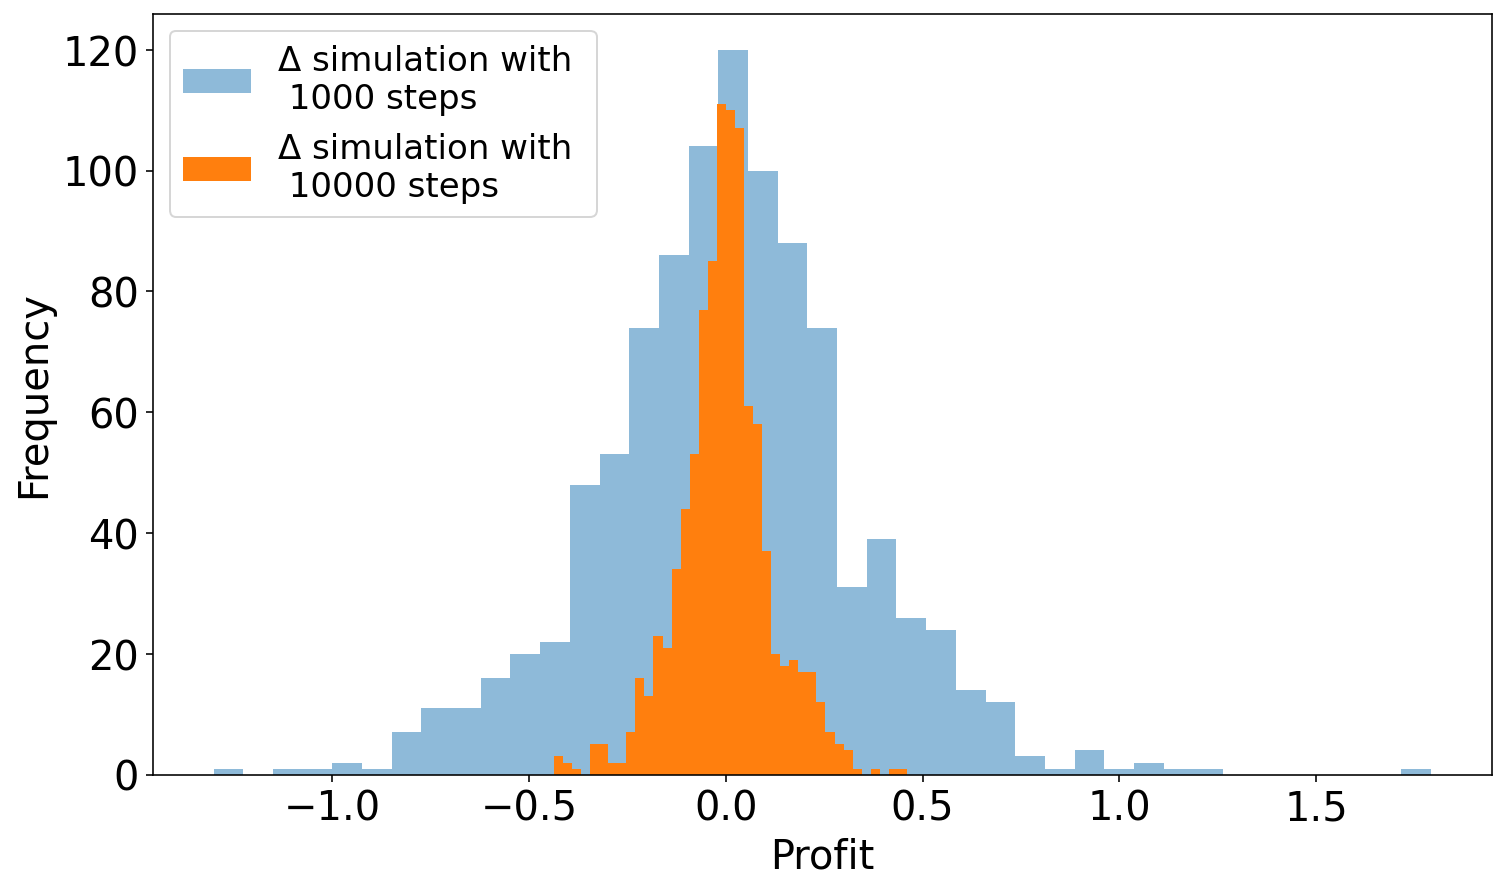

In [9]:
error1 = simulate_delta_hedging(S0,K,T,r,mu, 1000,1000)
error2 = simulate_delta_hedging(S0,K,T,r,mu, 10*1000,1000) 

plt.hist(error1, alpha = 0.5, bins = 'fd', label = '\u0394 simulation with \n 1000 steps')
plt.hist(error2, alpha = 1.0, bins = 'fd', label = '\u0394 simulation with \n 10000 steps')

plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)

plt.xlabel('Profit', size = 20)
plt.ylabel('Frequency', size = 20)
plt.legend(loc='upper left', fontsize = 17)

<span style='font-size:x-large'>Question 2</span>



Part 1



In [10]:
def simulate_delta_hedging_constant_vol( S0, K, T, r, mu, n_steps, n_paths): 
    stock, times = simulate_stock_price_mult(S0,mu,T,n_steps,n_paths)
    sigma = construct_vol(n_steps)
    sigma_T = sigma[-1]
    s_t, times = construct_s_t(n_steps)
    Pi = np.zeros(stock.shape)
    V = black_scholes_call_price(S0,0,K,T,r,sigma_T) 
    Pi[:,0] = V
    dt = T/n_steps #...
    for i in range(0,len(times)-1):
        q_t = black_scholes_delta_call(stock[:,i],times[i],K,T,r,sigma_T) 
        B_t = Pi[:,i]-q_t*stock[:,i]
        B_with_interest = B_t*np.exp(dt*r) 
        S_tplusdt=stock[:,i+1] 
        new_stock_value=q_t*S_tplusdt 
        Pi[:,i+1]=B_with_interest+new_stock_value
        
    S_T = stock[:,-1]
    final_balance=Pi[:,-1]

    error = final_balance - np.maximum((S_T-K), 0)
    return error

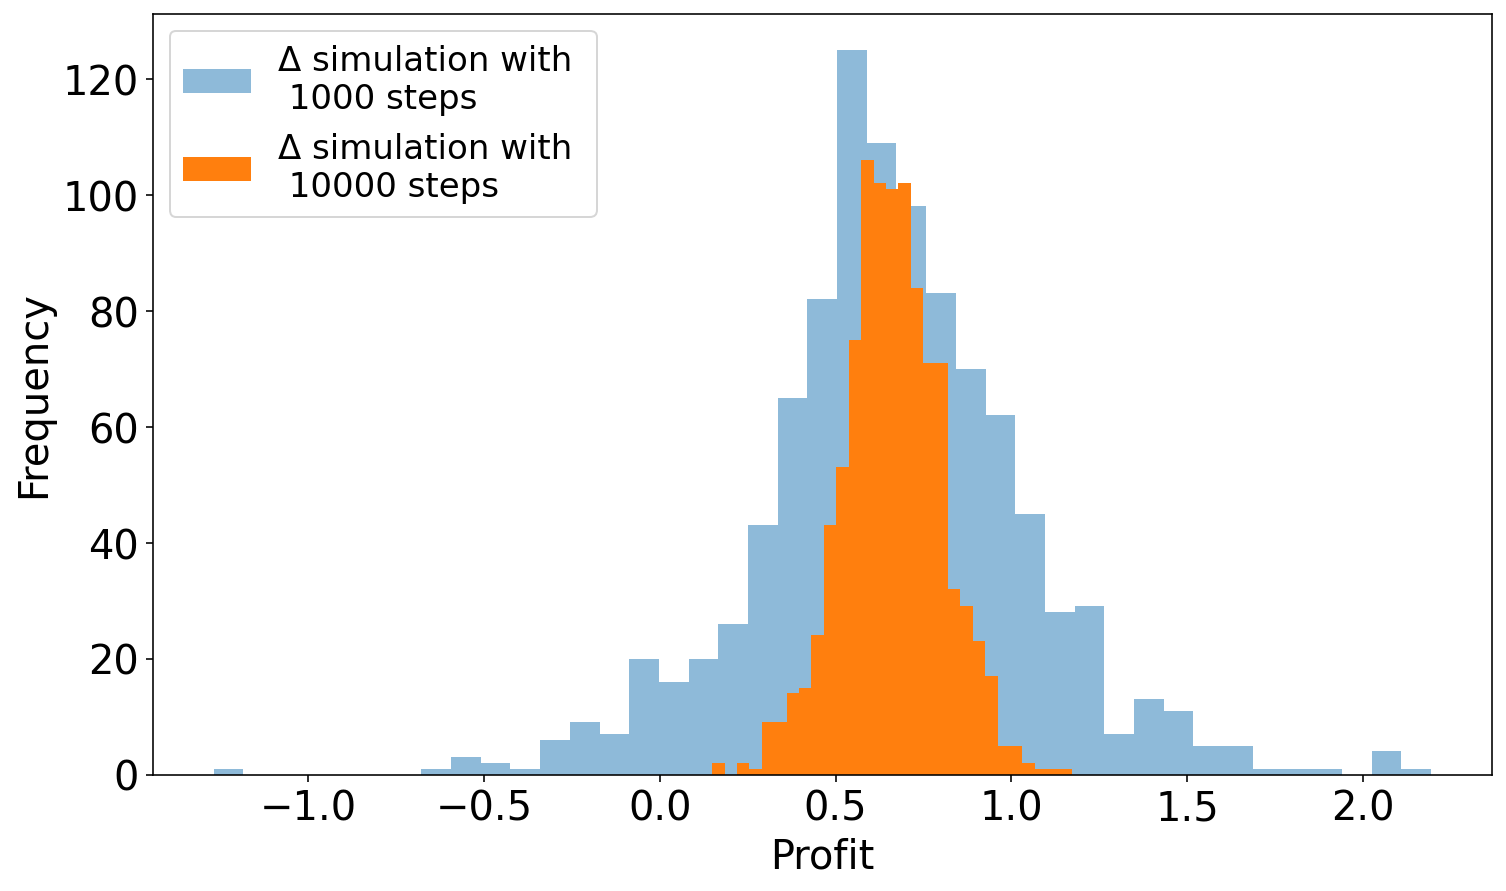

In [11]:
error1 = simulate_delta_hedging_constant_vol(S0,K,T,r, mu, 1000,1000)
error2 = simulate_delta_hedging_constant_vol(S0,K,T,r,mu, 10000,1000) 

plt.hist(error1, alpha = 0.5, bins = 'fd', label = '\u0394 simulation with \n 1000 steps')
plt.hist(error2, alpha = 1.0, bins = 'fd', label = '\u0394 simulation with \n 10000 steps')

plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)

plt.xlabel('Profit', size = 20)
plt.ylabel('Frequency', size = 20)
plt.legend(loc='upper left', fontsize = 17)

Part 2



In [12]:
def simulate_delta_hedging_constant_vol_2( S0, K, T, r, mu, n_steps, n_paths): 
    stock, times = simulate_stock_price_mult(S0,mu,T/2,n_steps,n_paths)
    sigma = construct_vol(n_steps)
    sigma_T = sigma[-1]
    Pi = np.zeros(stock.shape)
    V = black_scholes_call_price(S0,0,K,T,r,sigma_T) 
    Pi[:,0] = V
    dt = T/(2*n_steps) #...
    for i in range(0,len(times)-1):
        q_t = black_scholes_delta_call(stock[:,i],times[i],K,T,r,sigma_T) 
        B_t = Pi[:,i]-q_t*stock[:,i]
        B_with_interest = B_t*np.exp(dt*r) 
        S_tplusdt=stock[:,i+1] 
        new_stock_value=q_t*S_tplusdt 
        Pi[:,i+1]=B_with_interest+new_stock_value
    
    final_balance=Pi[:,-1]
    error = final_balance - black_scholes_call_price(stock[:,-1],0,K,T/2,r,sigma_T)
    return error

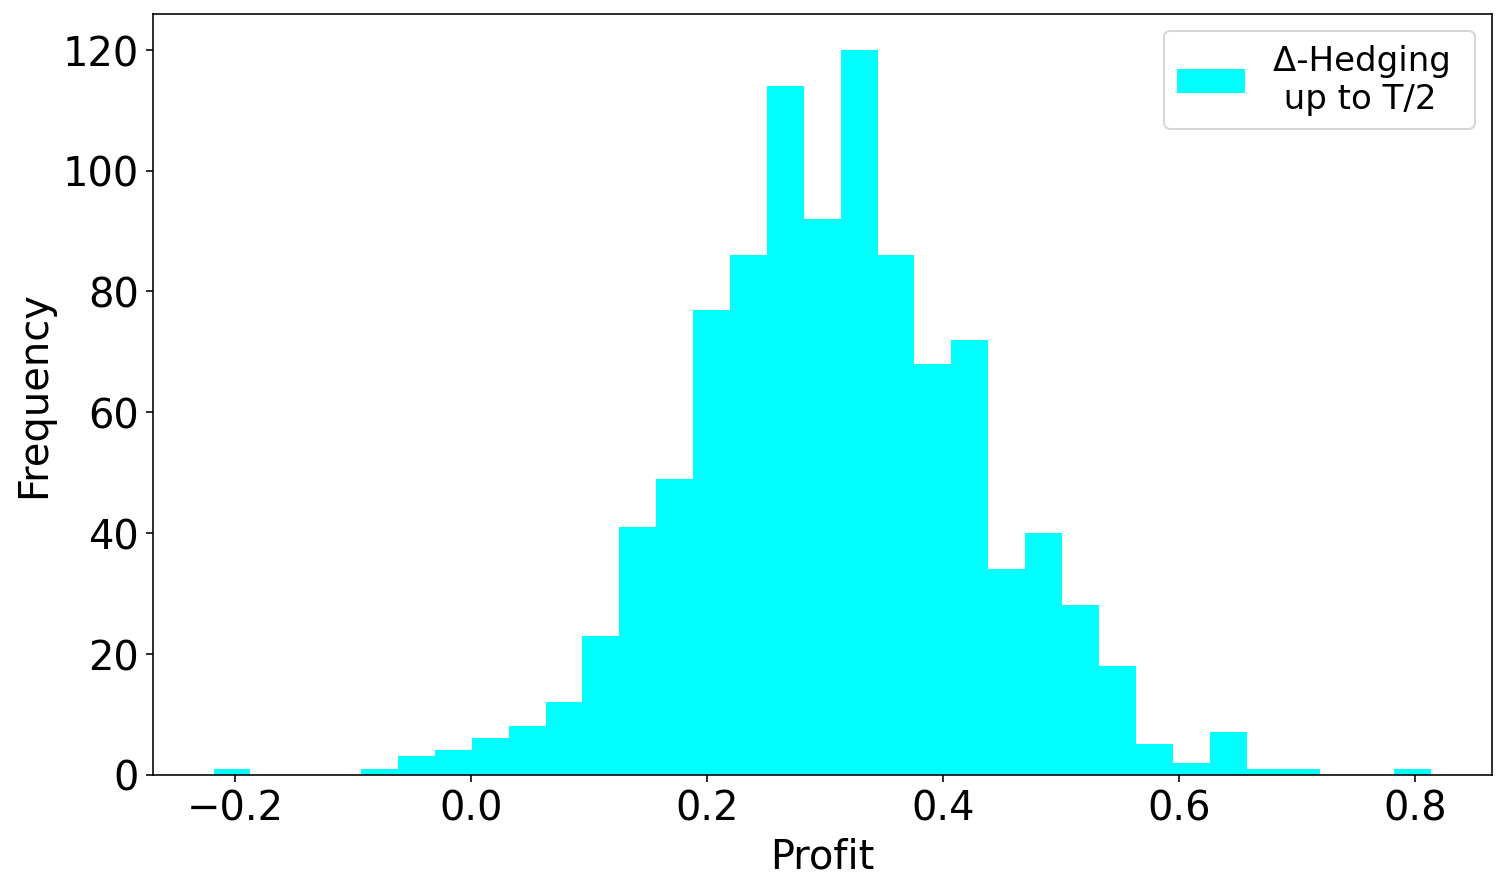

In [13]:
error1 = simulate_delta_hedging_constant_vol_2(S0,K,T,r,mu, 1000, 1000)
 
plt.hist(error1, label = '\u0394-Hedging \n up to T/2', color = 'cyan', bins = 'fd')

plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)

plt.xlabel('Profit', size = 20)
plt.ylabel('Frequency', size = 20)
plt.legend(loc='upper right', fontsize = 17)

<span style='font-size:x-large'>Question 3</span>


In [14]:
def simulate_gamma_hedging_const(S0, K, T, r, mu, n_steps, n_paths): 
    sigma = construct_vol(n_steps)
    sigma_T = sigma[-1]
    stock, times = simulate_stock_price_constant(S0, mu, sigma_T, T/2, n_steps, n_paths)
    d1_o, d2_o = compute_d1_and_d2( stock, times, K, T, r, sigma_T)
    d1_h, d2_h = compute_d1_and_d2( stock, times, S0, T, r, sigma_T)
    q_h = N_pdf(d1_o)/N_pdf(d1_h)
    q_s = black_scholes_delta_call(stock,times,K,T,r,sigma_T) - q_h*(black_scholes_delta_put(stock,times,S0,T,r,sigma_T))
    Vh_t = black_scholes_put_price(stock, times, S0, T, r, sigma_T)
    Pi = np.zeros(stock.shape)
    V = black_scholes_call_price(S0,0,K,T,r,sigma_T)
    Pi[:,0] = V #...
    dt = T/(2*n_steps)
    for i in range(0,len(times)-1): 
        B_t = Pi[:,i]-(q_s[:,i]*stock[:,i]+q_h[:,i]*Vh_t[:,i])
        B_with_interest = B_t*np.exp(dt*r) 
        new_stock_value=q_s[:,i]*stock[:,i+1] 
        new_option_value = q_h[:,i]*Vh_t[:,i+1]
        Pi[:,i+1]=B_with_interest+new_stock_value+new_option_value

    q = Pi[:,-1] - black_scholes_call_price(stock[:,-1],0,K,T/2,r,sigma_T)
    return q

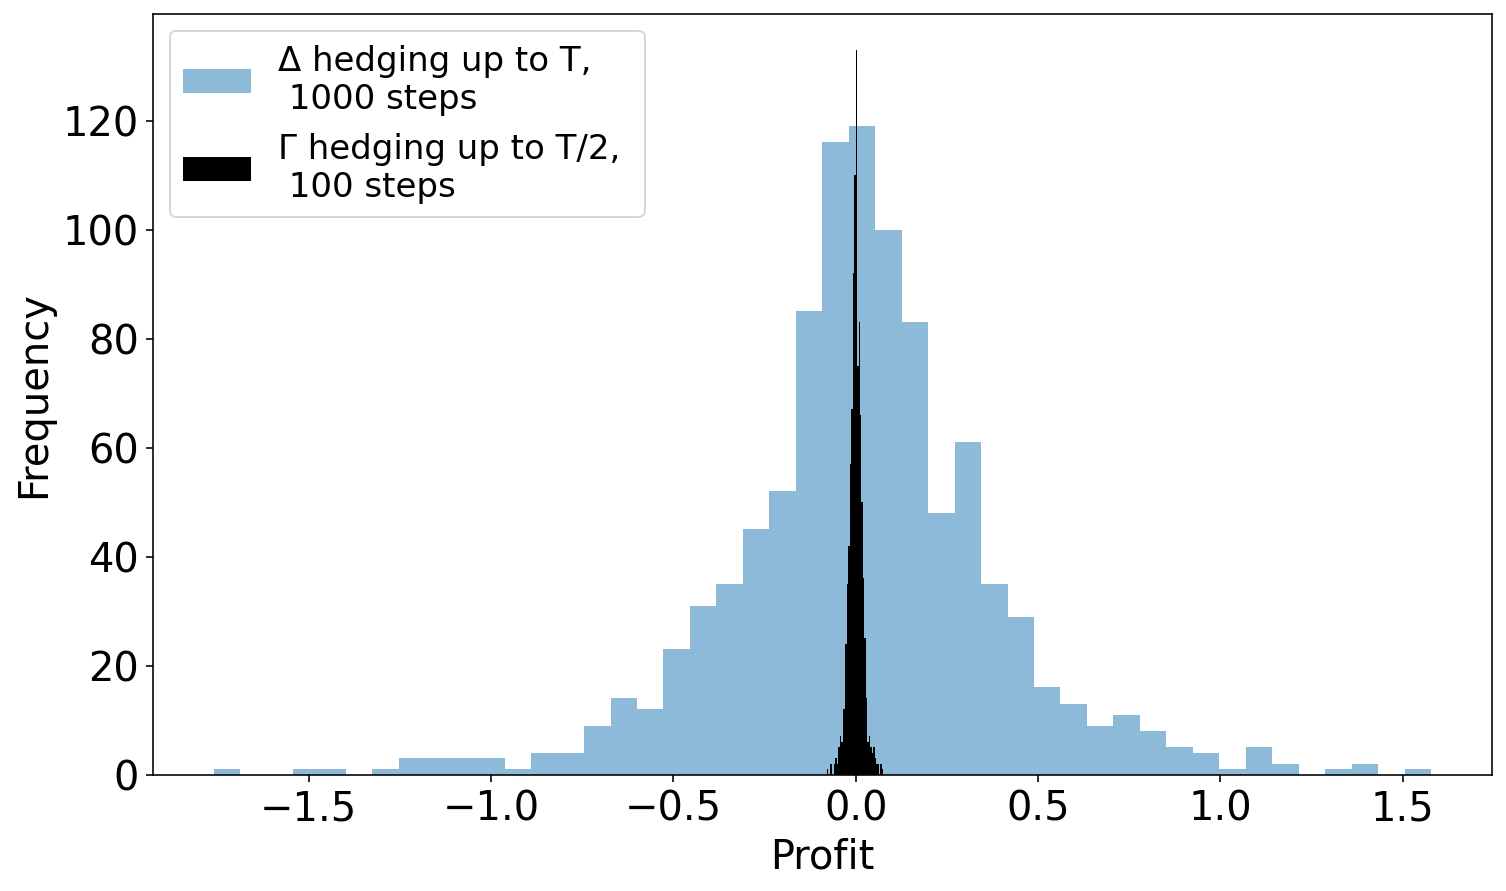

In [15]:
x_3 = simulate_gamma_hedging_const( S0, K, T, r, mu, 100, 1000)
x_4 = simulate_delta_hedging(S0, K, T, r, mu, 1000, 1000)

plt.hist(x_4, bins = 'fd', alpha = 0.5, label = '\u0394 hedging up to T, \n 1000 steps')
plt.hist(x_3, bins = 'fd', color = 'black', label = '\u0393 hedging up to T/2, \n 100 steps')

plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)

plt.xlabel('Profit', size = 20)
plt.ylabel('Frequency', size = 20)
plt.legend(loc='upper left', fontsize = 17)

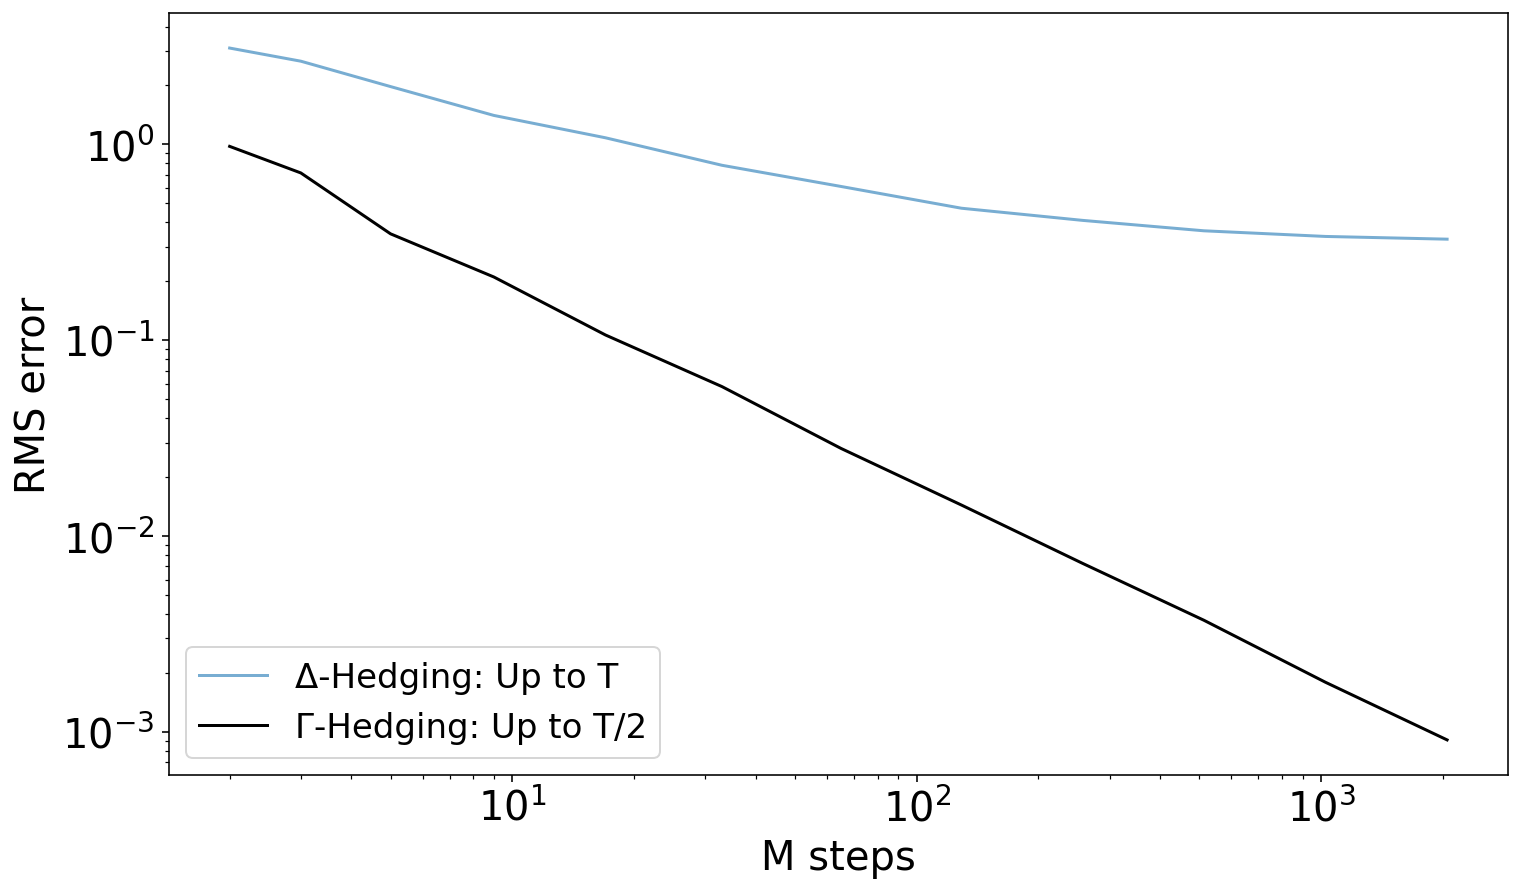

In [16]:
#Quantify convergence caulcuate the RMS error in our sample.
n_points = 12
n_s = np.zeros(n_points)
rms_error_1 = np.zeros(n_points)
rms_error_2 = np.zeros(n_points)
rms_error_3 = np.zeros(n_points)
rms_error_4 = np.zeros(n_points)
for i in range(0, n_points):
    n_s[i] = 2**i+1
    error_1 = simulate_delta_hedging(S0,K,T,r,mu, int(n_s[i]),1000)
    rms_error_1[i] = np.sqrt(np.mean(error_1**2))
    error_2 = simulate_delta_hedging_constant_vol(S0,K,T,r,mu, int(n_s[i]),1000)
    rms_error_2[i] = np.sqrt(np.mean(error_2**2))
    error_3 = simulate_delta_hedging_constant_vol_2(S0,K,T,r,mu, int(n_s[i]),1000)
    rms_error_3[i] = np.sqrt(np.mean(error_3**2))
    error_4 = simulate_gamma_hedging_const(S0,K,T,r,mu, int(n_s[i]),1000)
    rms_error_4[i] = np.sqrt(np.mean(error_4**2))
    

plt.xlabel('M steps', size = 20)
plt.ylabel('RMS error', size = 20)

plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)

plt.loglog(n_s, rms_error_3, alpha = 0.6, label =  '\u0394-Hedging: Up to T')
plt.loglog(n_s, rms_error_4, color = 'black', label =  '\u0393-Hedging: Up to T/2')

plt.legend(loc='lower left', fontsize = 17)

<span style='font-size:x-large'>Question 4</span>

In [17]:
def simulate_gamma_hedging( S0, K, T, r, mu, n_steps, n_paths): 
    sigma = construct_vol(n_steps)
    sigma_T = sigma[-1]
    stock, times = simulate_stock_price_mult(S0,mu,T/2,n_steps,n_paths)
    d1_o, d2_o = compute_d1_and_d2( stock, times, K, T, r, sigma_T)
    d1_h, d2_h = compute_d1_and_d2( stock, times, S0, T, r, sigma_T)
    q_h = N_pdf(d1_o)/N_pdf(d1_h)
    q_s = black_scholes_delta_call(stock,times,K,T,r,sigma_T) - q_h*(black_scholes_delta_put(stock,times,S0,T,r,sigma_T))
    Vh_t = black_scholes_put_price(stock, times, S0, T, r, sigma_T)
    Pi = np.zeros(stock.shape)
    V = black_scholes_call_price(S0,0,K,T,r,sigma_T) 
    Pi[:,0] = V
    dt = T/(2*n_steps) #...
    for i in range(0,len(times)-1): 
        B_t = Pi[:,i]-(q_s[:,i]*stock[:,i]+q_h[:,i]*Vh_t[:,i])
        B_with_interest = B_t*np.exp(dt*r) 
        S_tplusdt=stock[:,i+1] 
        new_stock_value=q_s[:,i]*S_tplusdt 
        new_option_value = q_h[:,i]*Vh_t[:,i+1]
        Pi[:,i+1]=B_with_interest+new_stock_value+new_option_value
        
    p = Pi[:,-1] - black_scholes_call_price(stock[:,-1],0,K,T/2,r,sigma_T)
    return p

In [18]:
y = simulate_gamma_hedging( S0, K, T, r, mu, 1000, 1000)

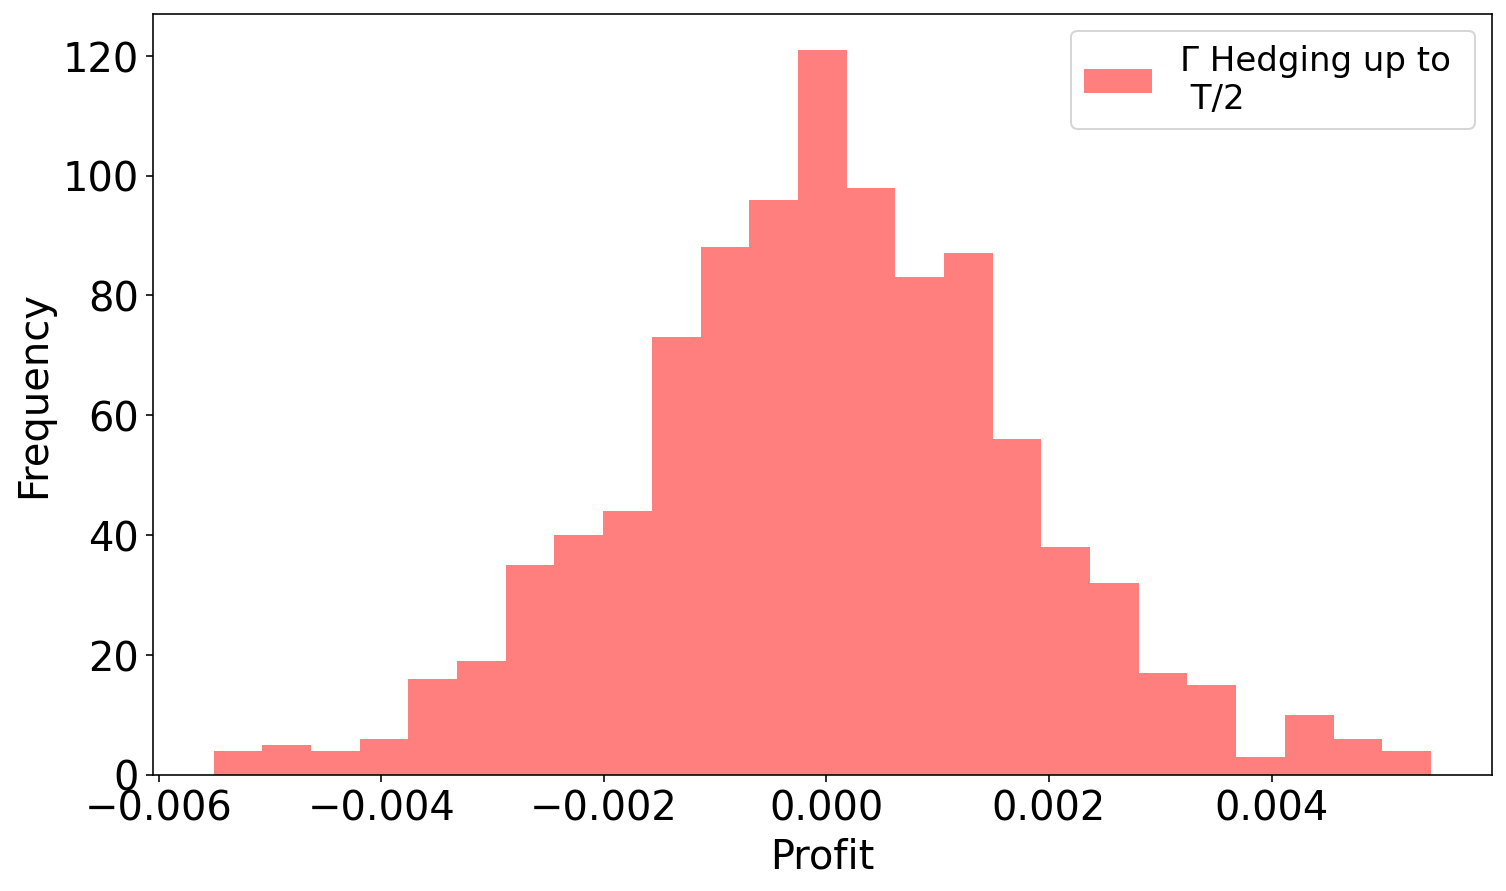

In [19]:
plt.hist(y, label = '\u0393 Hedging up to \n T/2', bins = 'fd', alpha = 0.5, color = 'red')

plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)

plt.xlabel('Profit', size = 20)
plt.ylabel('Frequency', size = 20)
plt.legend(loc='upper right', fontsize = 17)

<span style='font-size:x-large'>Computations</span>

In [20]:
s_t, times = construct_s_t(10)
V_0 = black_scholes_call_price(S0, times[0], K, T, r, s_t[0])

In [21]:
p = 95
alpha = scipy.stats.norm.ppf((1-p/100)/2)

price_d = np.mean(error1)
sigma_sample_delta = np.std(error1)
lower_d = price_d + alpha*sigma_sample_delta/np.sqrt(1000)
upper_d = price_d - alpha*sigma_sample_delta/np.sqrt(1000)

In [22]:
price_d

0.3091374814502038

In [23]:
price_g = np.mean(y)
sigma_sample_gamma = np.std(y)
lower_g = price_g + alpha*sigma_sample_gamma/np.sqrt(1000)
upper_g = price_g - alpha*sigma_sample_gamma/np.sqrt(1000)

In [24]:
price_g

-7.478671583445728e-06

<span style='font-size:x-large'>Table Values</span>

In [25]:
#print(V_0)
print('Price of option at time 0, P, is: ' + str(V_0) )
print('Confidence interval for p\u0394 = ' + '[{},{}]'.format(lower_d,upper_d) )
print('Confidence interval for p\u0393 = '+ '[{},{}]'.format(lower_g,upper_g) )

Price of option at time 0, P, is: 4.116069842784604
Confidence interval for pΔ = [0.3015335382073402,0.31674142469306743]
Confidence interval for pΓ = [-0.00011754867777635166,0.00010259133460946021]
